In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# loss = focal_loss(pos_weight=5, gamma=0, label_smoothing=0.0)
# # Y_true = tf.cast(np.array([0, 1, 1, 0, 1.00, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0]), tf.float32)
# # Y_pred = tf.cast(np.array([0, 1, 0, 1, 0.82, 0.9, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]), tf.float32)
# Y_pred = tf.cast(np.arange(0, 1.01, 0.05), tf.float32)
# Y_true = tf.ones_like(Y_pred, tf.float32)
# loss(Y_true, Y_pred)

In [3]:
%%writefile train.py

import os, gc, sys, time, random

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from google.cloud import storage

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow_addons.optimizers.utils import fit_bn

from tensorflow.python.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.mixed_precision import experimental as mixed_precision

import transformers
from transformers import TFAutoModel, AutoTokenizer
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors

from one_cycle_scheduler import OneCycleScheduler

import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)


def focal_loss(gamma=2., pos_weight=1, label_smoothing=0.05):
    def binary_focal_loss(labels, p):
        labels = tf.dtypes.cast(labels, dtype=p.dtype)
        if label_smoothing is not None:
            labels = (1 - label_smoothing) * labels + label_smoothing * 0.5

        # Predicted probabilities for the negative class
        q = 1 - p

        # For numerical stability (so we don't inadvertently take the log of 0)
        p = tf.math.maximum(p, K.epsilon())
        q = tf.math.maximum(q, K.epsilon())

        # Loss for the positive examples
        pos_loss = -(q ** gamma) * tf.math.log(p) * pos_weight

        # Loss for the negative examples
        neg_loss = -(p ** gamma) * tf.math.log(q)

        # Combine loss terms
        loss = labels * pos_loss + (1 - labels) * neg_loss

        return loss
    
    return binary_focal_loss


def build_model(model_id='jplu/tf-xlm-roberta-large', max_len=192,
                optimizer='LAMB', lr=2e-5, weight_decay=1e-6,
                loss_fn='bce', label_smoothing=0.01,
                pos_weight=5, gamma=2.0,  ## focal loss
                dropout=0.2,
                amp=False, **kwargs):
    transformer = TFAutoModel.from_pretrained(model_id)

    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    if dropout > 0:
        cls_token = Dropout(dropout)(cls_token)
    out = Dense(1, activation='sigmoid')(cls_token)
    model = Model(inputs=input_word_ids, outputs=out)

    if loss_fn == 'focal':
        loss = focal_loss(pos_weight=pos_weight, gamma=gamma, label_smoothing=label_smoothing)
    elif loss_fn == 'bce':
        loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing)

    if optimizer == 'LAMB':
        opt = tfa.optimizers.LAMB(lr=lr, weight_decay_rate=weight_decay)
    elif optimizer == 'AdamW':
        opt = tfa.optimizers.AdamW(lr=lr, weight_decay=weight_decay)

    if amp:
        print('Using auto_mixed_precision.')
        tf.config.optimizer.set_jit(True)
        tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
        opt = tf.keras.mixed_precision.experimental.LossScaleOptimizer(opt, 'dynamic')

    model.compile(
            optimizer=opt,
            loss=loss,
            metrics=['accuracy',
                     tf.keras.metrics.AUC(name='auc'),
                    ]
        )

    return model


def save_fig(filename, path, gcs):
    plt.gcf().savefig(filename)
    plt.close()
    # init GCS client and upload file
    client = storage.Client()
    bucket = client.get_bucket(gcs)
    blob   = bucket.blob(f'{path}/{filename}')
    content = blob.upload_from_filename(filename=filename)


def train_model(model, strategy,
                checkpoint_path, dataset,
                seed=0, epochs=30, steps_per_epoch=250,
                lr=2e-5, one_cycle=True, warm_up=1,
                mom_min=0.85, mom_max=0.95,
                div_factor=100, final_div_factor=250,
                batch_size=28, callback=None,
                **kwargs):
    batch_size = batch_size * strategy.num_replicas_in_sync
    print('batch_size:', batch_size)

    array = np.load(dataset)
    x_train, x_valid, x_test, y_train, y_valid = [array[k] for k in list(array)]
    # Shuffle
    x_train = pd.DataFrame(np.concatenate([x_train.T, [y_train]]).T
                ).sample(frac=1, random_state=seed).values
    assert abs(x_train[...,:-1] - x_train[...,:-1].astype('int32')).max() == 0
    x_train, y_train = x_train[...,:-1].astype('int32'), x_train[...,-1].astype('float32')
    print(x_train.shape, x_valid.shape, x_test.shape, y_train.shape, y_valid.shape)

    ## Set Datasets
    AUTO = tf.data.experimental.AUTOTUNE
    train_dataset = (
        tf.data.Dataset
        .from_tensor_slices((x_train, y_train))
        .repeat()
        .shuffle(2048)
        .batch(batch_size)
        .prefetch(AUTO)
    )

    valid_dataset = (
        tf.data.Dataset
        .from_tensor_slices((x_valid, y_valid))
        .batch(batch_size)
        .cache()
        .prefetch(AUTO)
    )

    test_dataset = (
        tf.data.Dataset
        .from_tensor_slices(x_test)
        .batch(batch_size)
        .prefetch(AUTO)
    )


    ## Train
    callbacks = [] if callback is None else [callback]
    callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_auc', min_delta=1e-4, mode='max',
                                                      patience=6, verbose=1, restore_best_weights=True))

    if one_cycle:
        callbacks.append(OneCycleScheduler(lr_max=lr, steps=steps_per_epoch*epochs,
                                           mom_min=mom_min, mom_max=mom_max, phase_1_pct=warm_up/epochs,
                                           div_factor=div_factor, final_div_factor=final_div_factor))
    else:
        callbacks.append(tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.31,
                                                              patience=2, cooldown=1,
                                                              verbose=1, mode='max', min_delta=1e-4))

    callbacks.append(tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                        monitor='val_auc', mode='max',
                                                        verbose=1,
                                                        save_best_only=True,
                                                        save_weights_only=True))
    print(callbacks)

#     try:
    history = model.fit(
        train_dataset,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_dataset,
        epochs=epochs,
        callbacks=callbacks,
    )
#     except Exception as ex:
#         print(ex)
#         history = model.history


    # load best
    if epochs > 1:
        # latest = tf.train.latest_checkpoint(checkpoint_dir)
        with strategy.scope():
            model.load_weights(checkpoint_path)

    return (model,
            model.predict(valid_dataset, verbose=1),
            model.predict(test_dataset, verbose=1))

def plot_history(history, path, bucket):
    ## Eval
    fig, axs = plt.subplots(1, 3, figsize=(18,4))
    # Plot training & validation loss values
    ax = axs[0]
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title('Model loss')
    ax.set_yscale('log')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Test'], loc='lower left')

    # Plot training & validation accuracy values
    ax = axs[1]
    ax.plot(history.history['accuracy'])
    ax.plot(history.history['val_accuracy'])
    ax.set_title('Model accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation accuracy values
    ax = axs[2]
    ax.plot(history.history['auc'])
    ax.plot(history.history['val_auc'])
    ax.set_title('Model AUC')
    ax.set_ylabel('AUC')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Test'], loc='upper left')

    save_fig('history.png', path, bucket)




##################
###### MAIN ######
##################

def train(gcs='hm-eu-w4', path='jigsaw/test',
          seed=0, tpu_id=None, **kwargs):
    params = dict(locals())
    params.update(kwargs)
    params = pd.DataFrame(params, index=[0])
    kw_params = params.T[0].to_dict()
    print(params.T)
    gc.collect()

    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

    if tpu_id is None:
        with open('tpu', 'r') as content_file:
            tpu_id = content_file.read()
            print(dict(tpu_id=tpu_id))

    ## Detect hardware, return appropriate distribution strategy
    try:
        # TPU detection. No parameters necessary if TPU_NAME environment variable is
        # set: this is always the case on Kaggle.
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_id)
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    else:
        # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
        strategy = tf.distribute.get_strategy()
    print("REPLICAS: ", strategy.num_replicas_in_sync)

    ## Configuration
    path = f'{path}/{time.strftime("%Y%m%d_%H%M%S")}_{tpu_id}'
    gcs_path = f'gs://{gcs}/{path}'
    checkpoint_path = f"{gcs_path}/best_model.tf"
    print('gcs_path:', gcs_path)

    ## Load and Train
    with strategy.scope():
        model = build_model(**kw_params)
    model, preds, sub = train_model(model, strategy, checkpoint_path, **kw_params)
    
    ## Save results
    plot_history(model.history, path, gcs)
    history = pd.DataFrame(model.history.history)
    print(history)
    history.to_csv(f'{gcs_path}/history.csv', index=False)

    ## Load Dataset
    valid = pd.read_csv('../input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
#     test = pd.read_csv('../input/jigsaw-multilingual-toxic-comment-classification/test.csv')
    sub = pd.read_csv('../input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

    valid['pred'] = preds
    valid.to_csv(f'{gcs_path}/valid_oof.csv', index=False)

    ax = valid.groupby('toxic').pred.hist(bins=100, log=True, alpha=0.5)
    plt.legend([0, 1])
    save_fig('valid_hist.png', path, gcs)

    ax = valid[valid.toxic == 1].groupby('lang').pred.hist(bins=50, log=True, alpha=0.34)
    plt.legend(valid.lang.unique())
    save_fig('valid_toxic_hist.png', path, gcs)

    valid_auc = roc_auc_score(valid.toxic, valid.pred)
    print('AUC:', valid_auc,
          'toxic:', valid.toxic.mean(),
          'pred:', valid.pred.mean(),
          'ratio:', (valid.pred > 0.5).mean())

    # over sample toxic
    bal_valid = valid.append(valid[valid.toxic == 1], ignore_index=True)
    print('AUC_bal:', roc_auc_score(bal_valid.toxic, bal_valid.pred),
          'toxic:', bal_valid.toxic.mean(),
          'pred:', bal_valid.pred.mean(),
          'ratio:', (bal_valid.pred > 0.5).mean())

    ## Submission
    sub['toxic'] = sub
    sub.to_csv(f'{gcs_path}/submission.csv', index=False)

    ax = sub.toxic.hist(bins=100, log=True)
    save_fig('sub_hist.png', path, gcs)
    print('mean:', sub.toxic.mean(), 'ratio:', (sub.toxic > 0.5).mean())
    
    ## Save params
    params['auc'] = valid_auc
    params.to_csv(f'{gcs_path}/params{valid_auc:04f}.csv', index=False)
    print(params.T)

    return valid_auc

Overwriting train.py


In [4]:
!pylint train.py

No config file found, using default configuration
************* Module train
E:108, 0: invalid syntax (<string>, line 108) (syntax-error)


In [5]:
import numpy as np
from train import train

best = (0, None)

for i in range(1):
    params = dict(
        optimizer=np.random.choice(['LAMB', 'AdamW']),
        lr=10**np.random.uniform(low=-5.5, high=-4),
        weight_decay=10**np.random.uniform(low=-6.5, high=-4.5),
        loss_fn='focal',
        label_smoothing=np.random.uniform(low=0.01, high=0.04),
        pos_weight=np.random.uniform(low=1.5, high=5),
        gamma=np.random.uniform(low=1.0, high=2.5),
        warm_up=np.random.uniform(low=1, high=5),
        epochs=1, #np.random.randint(low=28, high=38),
        steps_per_epoch=4,
        amp=False,
        dataset='gs://hm-eu-w4/jigsaw/translated-distilled-ds4/*.tfrec',
        path=f'jigsaw/test',
        tpu_id='t8a',
        seed=np.random.randint(99),
    )

    auc = train(**params)
    if auc > best[0]:
        best = (auc, i, params)
        print('Best params:', best)

print('### Grid Search Done:')
print(best)

                                                                 0
kwargs                                                         NaN
tpu_id                                                         t8a
seed                                                            58
path                                                   jigsaw/test
gcs                                                       hm-eu-w4
optimizer                                                     LAMB
lr                                                     2.27075e-05
weight_decay                                           7.32631e-07
loss_fn                                                      focal
label_smoothing                                          0.0344378
pos_weight                                                 2.54279
gamma                                                      1.72128
warm_up                                                    2.68162
epochs                                                        

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


REPLICAS:  8
gcs_path: gs://hm-eu-w4/jigsaw/test/20200427_173201_t8a
batch_size: 224
(436001, 192) (8000, 192) (63812, 192) (436001,) (8000,)
[<tensorflow.python.keras.callbacks.EarlyStopping object at 0x7f00182e2710>, <one_cycle_scheduler.OneCycleScheduler object at 0x7f00182e2748>, <tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x7f00182e2860>]
Train for 4 steps, validate for 36 steps


/home/henrique/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)
/home/henrique/.local/lib/python3.6/site-packages/tensorflow_core/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


3/4 [=====================>........] - ETA: 1:31 - loss: 0.4132 - accuracy: 0.5432 - auc: 0.4853
Epoch 00001: val_auc improved from -inf to 0.51111, saving model to gs://hm-eu-w4/jigsaw/test/20200427_173201_t8a/best_model.tf
285/285 [==============================] - 79s 278ms/step
       loss  accuracy       auc  val_loss  val_accuracy   val_auc
0  0.406935   0.55692  0.497977  0.318089       0.84625  0.511112
AUC: 0.5125415811026648 toxic: 0.15375 pred: 0.29489315 ratio: 0.0
AUC_bal: 0.5125415811026648 toxic: 0.26652221018418204 pred: 0.29495004 ratio: 0.0
mean: 31905.5 ratio: 0.9999843289663386
                                                                 0
kwargs                                                         NaN
tpu_id                                                         t8a
seed                                                            58
path                                                   jigsaw/test
gcs                                                       hm

In [6]:
# import pdb; pdb.pm()

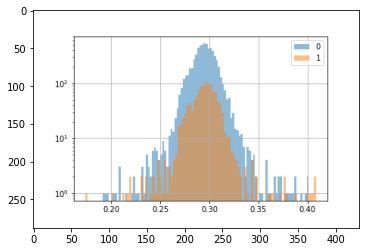

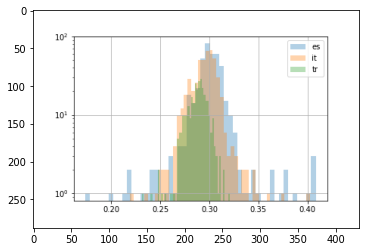

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('valid_hist.png')
_ = plt.imshow(img)
plt.show()
img = mpimg.imread('valid_toxic_hist.png')
_ = plt.imshow(img)

In [8]:
# import numpy as np
# from train import train

# import optuna
# from optuna.integration import KerasPruningCallback

# # minimize the objective over the space
# def objective(trial):
#     # define the search space
#     args = dict(
#         optimizer='LAMB', #trial.suggest_categorical('optimizer', ['LAMB', 'AdamW']),
#         lr=trial.suggest_loguniform('lr', 4e-6, 1e-4),
#         weight_decay=trial.suggest_loguniform('weight_decay', 1e-7, 1e-4),
#     #     loss_fn='focal',
#         label_smoothing=trial.suggest_uniform('label_smoothing', 0.001, 0.05),
#     #     pos_weight=trial.suggest_uniform('pos_weight', 1, 6),
#     #     gamma=trial.suggest_uniform('gamma', 0.0, 3.0)),
#         epochs=1,
#         stages=1000,
#         dataset='../input/jigsaw-mltc-ds/jigsaw_mltc_ds436001s.npz',
#         gcs='hm-eu-w4',
#         path=f'jigsaw/h000',
#         tpu_id='t8a',
#         seed=3,
#         callback=KerasPruningCallback(trial, "val_auc"),
#     )
#     return -train(**args)

# study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
# study.optimize(objective, n_trials=2)
# pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
# complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
# print("Study statistics: ")
# print("  Number of finished trials: ", len(study.trials))
# print("  Number of pruned trials: ", len(pruned_trials))
# print("  Number of complete trials: ", len(complete_trials))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: ", trial.value)

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))